## This script fits simple cross validated SVM using single fit and alpy

## It should be straightforward to go from this script to running experiments on any fingerprint/compound pair

In [13]:
% load_ext autoreload
% autoreload 2
import matplotlib.pylab as plt
% matplotlib inline
import sys
import seaborn
sys.path.insert(0, "../mlls2015")
sys.path.insert(0, "..")
import training_data
from training_data.datasets import CVBaseChemDataset
import bunch
import numpy as np
from bunch import Bunch
import os
import logging
from experiments.utils import wac_score
from misc.utils import config_log_to_file

import copy
from models.balanced_models import *

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

import alpy_addons
from alpy_addons.active import ActiveLearner
from alpy.datasets.generate import get_2d_gaussians
from alpy_addons.monitors import *
from alpy.oracle import SimulatedOracle
from alpy.strategy import UncertaintySampling, PassiveStrategy

from alpy_addons.strategy import UncertaintySampling
from alpy.utils import mask_unknowns

from sklearn.grid_search import GridSearchCV

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
opts = Bunch({"C_min": -7, 
              "C_max": 6,
              "max_iter": 80000000,
              "n_folds": 5, 
              "preprocess": "clip01", #"max_abs", 
              "fold": 2, 
              "compound": "SERT", 
              "representation": "MACCS", 
              "jaccard": 0, 
              "rng": 777, 
              "name": "test_svm_al",
              "batch_size": 100,
              "output_dir": "/Users/kudkudak/code/mlls2015/"})

In [15]:
config_log_to_file(os.path.join(opts.output_dir, opts.name + ".log"), clear_log_file=True)
logger = logging.getLogger("fit_svm")
logger.info(opts.__dict__)
logger.info(opts.name)

INFO:fit_svm:{}
INFO:fit_svm:test_svm_al


In [16]:
data = CVBaseChemDataset(compound=opts.compound, representation=opts.representation, n_folds=opts.n_folds, rng=opts.rng,
                       preprocess=opts.preprocess)
(X_train, y_train), (X_valid, y_valid) = data.get_data(fold=opts.fold)
if opts.jaccard:
    K_train, K_valid = calculate_jaccard_kernel(data=data, fold=opts.fold)

In [17]:
class EstimatorMonitor(BaseMonitor):
    def __init__(self):
        super(EstimatorMonitor, self).__init__(name="EstimatorMonitor", short_name="est_mon")

    def __call__(self, estimator, X, labels):
        if not isinstance(estimator, BaseEstimator):
            raise TypeError("Got bad estimator: {}".format(type(estimator)))

        return copy.copy(estimator)

class SimpleLogger(BaseMonitor):
    def __init__(self, batch_size=10, frequency=1):
        self.n_iter = 0
        self.batch_size = batch_size
        super(SimpleLogger, self).__init__(name="SimpleLogger", short_name="simple_logger", frequency=frequency)

    def __call__(self, estimator, X, labels):
        logger.info("iter " + str(self.n_iter))
        self.n_iter += self.batch_size
        return 0
    
y_train_masked = mask_unknowns(y_train, np.random.choice(X_train.shape[0], size=X_train.shape[0] - 100, replace=False))

In [18]:
# TODO: add TP/FN/TN/FP recording
monitors = []

monitors.append(MetricMonitor(name="wac_score",
                        short_name="wac",
                        function=wac_score,
                        ids="all",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_labeled",
                        short_name="wac_labeled",
                        function=wac_score,
                        ids="known",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_unlabeled",
                        short_name="wac_unlabeled",
                        function=wac_score,
                        ids="unknown",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_valid",
                        short_name="wac_valid",
                        function=wac_score,
                        frequency=1,
                        X=X_valid,
                        y=y_valid))

monitors.append(SimpleLogger(batch_size=opts.batch_size))

monitors.append(EstimatorMonitor())

In [19]:
def wac_scoring(estimator, X, y):
    return wac_score(y, estimator.predict(X))

In [20]:
m = GridSearchCV(SVC(random_state=opts.rng, kernel='precomputed'), 
                 param_grid = {"C": [10**c for c in range(opts.C_min, opts.C_max + 1)]}, 
                 cv=3, 
                 scoring=wac_scoring, 
                 error_score=0.)

In [21]:
def tanimoto(X, W, b=None):
    if not hasattr(X, "toarray"):
        W = W.toarray()

    XW = X.dot(W.T)
    XX = X.multiply(X).sum(axis=1).reshape(-1, 1)
    WW = W.multiply(W).sum(axis=1).reshape(1, -1)
    return XW.toarray() / (XX+WW-XW)


In [22]:
uncert_model = ActiveLearner(strategy=UncertaintySampling(),
                             random_state=opts.rng,
                             batch_size=opts.batch_size,
                              oracle=SimulatedOracle(sample_budget=np.inf),
                              estimator=m)

In [23]:
K_train = tanimoto(X_train, X_train)
K_valid = tanimoto(X_valid, X_train)

monitors = []

monitors.append(MetricMonitor(name="wac_score",
                        short_name="wac",
                        function=wac_score,
                        ids="all",
                        frequency=1))

monitors.append(MetricMonitor(name="wac_score_valid",
                        short_name="wac_valid",
                        function=wac_score,
                        frequency=1,
                        X=K_valid,
                        y=y_valid))

monitors.append(SimpleLogger(batch_size=opts.batch_size))

monitors.append(EstimatorMonitor())

In [24]:
uncert_model.fit(K_train, y_train_masked, monitors=monitors)

INFO:fit_svm:iter 0


0.599380393996
{'C': 100}
0.633595149511

INFO:fit_svm:iter 100



{'C': 100}
0.655951489716

INFO:fit_svm:iter 200



{'C': 10}
0.646385156202

INFO:fit_svm:iter 300



{'C': 100}
0.651787360421

INFO:fit_svm:iter 400



{'C': 100}
0.668098611593

INFO:fit_svm:iter 500



{'C': 100}
0.655254985234

INFO:fit_svm:iter 600



{'C': 100}
0.681248512424

INFO:fit_svm:iter 700



{'C': 100}
0.684181381576

INFO:fit_svm:iter 800



{'C': 100}
0.69620682433

INFO:fit_svm:iter 900



{'C': 100}
0.709241550702

INFO:fit_svm:iter 1000



{'C': 100}
0.713611348864

INFO:fit_svm:iter 1100



{'C': 100}
0.721039846583

INFO:fit_svm:iter 1200



{'C': 1000}
0.743905723906

INFO:fit_svm:iter 1300



{'C': 100}
0.748179072173

INFO:fit_svm:iter 1400



{'C': 100}
0.753761204184

INFO:fit_svm:iter 1500



{'C': 100}
0.764161493524

INFO:fit_svm:iter 1600



{'C': 100}
0.771901403783

INFO:fit_svm:iter 1700



{'C': 100}
0.781556883123

INFO:fit_svm:iter 1800



{'C': 1000}
0.783572082386

INFO:fit_svm:iter 1900



{'C': 100}
0.793221337971

INFO:fit_svm:iter 2000



{'C': 100}
0.796478510241

INFO:fit_svm:iter 2100



{'C': 100}
0.800040544724

INFO:fit_svm:iter 2200



{'C': 1000}
0.800513920549

INFO:fit_svm:iter 2300



{'C': 1000}
0.802880865147

INFO:fit_svm:iter 2400



{'C': 1000}
0.805472738841

INFO:fit_svm:iter 2500



{'C': 1000}
0.815188268278

INFO:fit_svm:iter 2600



{'C': 1000}
0.817408396967

INFO:fit_svm:iter 2700



{'C': 100}
0.819443288753

INFO:fit_svm:iter 2800



{'C': 1000}
0.821863821265

INFO:fit_svm:iter 2900



{'C': 100}
0.82620759701

INFO:fit_svm:iter 3000



{'C': 100}
0.828293558042

INFO:fit_svm:iter 3100



{'C': 100}
0.831759021048

INFO:fit_svm:iter 3200



{'C': 100}
0.832382418379

INFO:fit_svm:iter 3300



{'C': 1000}
0.8329511696

INFO:fit_svm:iter 3400



{'C': 100}
0.833698530704

INFO:fit_svm:iter 3500



{'C': 10}
0.833637775472

INFO:fit_svm:iter 3600



{'C': 10}
0.834650384273

INFO:fit_svm:iter 3700



{'C': 10}
0.836321809272

INFO:fit_svm:iter 3800



{'C': 10}
0.836181671882

INFO:fit_svm:iter 3900



{'C': 100}
0.84038887217

INFO:fit_svm:iter 4000



{'C': 10}
0.839467291877

INFO:fit_svm:iter 4100



{'C': 100}


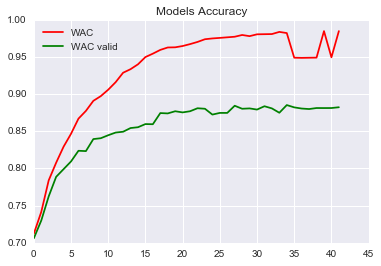

In [25]:
### Plot model accuracy
plt.clf()
unc_wac = uncert_model._monitor_outputs['wac']
unc_wac_valid = uncert_model._monitor_outputs['wac_valid']
t = np.arange(len(unc_wac))
p1 = plt.plot(t, unc_wac, 'r')
p2 = plt.plot(t, unc_wac_valid, 'g')
plt.legend((p1[0], p2[0]), ('WAC', 'WAC valid'), loc='best')
plt.title('Models Accuracy')
plt.show()

In [26]:
def generate_time_report(monitor_outputs):
    # Returns dict with percentage/amount of time spent in each section (all keys with "_time" suffix)
    report = {}
    total_time = float(sum(monitor_outputs['iter_time']))
    for k in monitor_outputs:
        if k.endswith("_time"):
            report[k] = [sum(monitor_outputs[k]), sum(monitor_outputs[k]) / total_time]
    return report

In [27]:
generate_time_report(uncert_model._monitor_outputs)

{'est_mon_time': [0.002071857452392578, 8.149042877143728e-06],
 'fit_time': [226.7475986480713, 0.8918450936567576],
 'iter_time': [254.24549651145935, 1.0],
 'oracle_time': [0.0436253547668457, 0.00017158752216041482],
 'simple_logger_time': [0.029647111892700195, 0.0001166082085995334],
 'strategy_time': [9.823477029800415, 0.03863776218100151],
 'wac_time': [11.203063488006592, 0.04406396039153302],
 'wac_valid_time': [2.004322052001953, 0.007883412211832882]}